# Forex predictions using Machine Learning
# Loading and preparing data

In [165]:
# import pandas as pd
# df = pd.read_csv("EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")
# df.tail()
import yfinance as yf
import pandas_ta as ta
df = yf.download(tickers = 'BTC-USD', period='max')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [166]:
#Check if any zero volumes are available
indexZeros = df[ df['Volume'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Volume"] == 0 )]
df.isna().sum()
df = df.reset_index()

In [167]:
df = df.iloc[1000:,].copy()

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1000,2017-06-13,2680.909912,2789.040039,2650.379883,2717.020020,2717.020020,1781200000
1001,2017-06-14,2716.879883,2786.830078,2412.939941,2506.370117,2506.370117,1696560000
1002,2017-06-15,2499.580078,2534.709961,2212.959961,2464.580078,2464.580078,2026259968
1003,2017-06-16,2469.570068,2539.919922,2385.149902,2518.560059,2518.560059,1195190016
1004,2017-06-17,2514.010010,2685.189941,2484.959961,2655.879883,2655.879883,1534509952


In [168]:
import numpy as np
import pandas_ta as ta
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
backrollingN = 6
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [169]:
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
1164,2017-11-24,8074.020020,8374.160156,7940.930176,8253.690430,8253.690430,5058610176,442.677361,66.107411,8157.545166,6758.857483,5521.423621,4353.851308,65.611426,45.472807,35.033692,41.737298,-0.551028
1165,2017-11-25,8241.709961,8790.919922,8191.149902,8790.919922,8790.919922,4342060032,450.533652,70.985898,8491.034912,6835.490735,5573.846118,4392.867744,64.118529,47.512711,35.681023,57.412130,0.176289
1166,2017-11-26,8789.040039,9522.929688,8775.589844,9330.549805,9330.549805,5475579904,465.376938,74.894879,9149.259766,6928.616736,5632.979492,4434.998680,69.296346,50.311008,36.987966,182.252665,1.542398
1167,2017-11-27,9352.719727,9818.349609,9352.719727,9818.349609,9818.349609,5653320192,466.498295,77.805763,9585.534668,7034.308228,5702.849487,4479.352177,78.689638,54.845407,38.924571,294.438909,2.478835
1168,2017-11-28,9823.429688,10125.700195,9736.299805,10058.799805,10058.799805,6348819968,462.642702,79.092620,9931.000000,7143.065222,5775.758734,4525.412801,90.355843,60.497402,41.467788,395.193352,3.292003


# Target categories

In [254]:
#Target flexible way
pipdiff = 80000000*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [255]:
df["Daily_Return"] = df["Close"].pct_change().shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,Daily_Return,mytarget
1164,8074.020020,8374.160156,7940.930176,8253.690430,8253.690430,5058610176,442.677361,66.107411,8157.545166,6758.857483,5521.423621,4353.851308,65.611426,45.472807,35.033692,41.737298,-0.551028,0.065090,2.0
1165,8241.709961,8790.919922,8191.149902,8790.919922,8790.919922,4342060032,450.533652,70.985898,8491.034912,6835.490735,5573.846118,4392.867744,64.118529,47.512711,35.681023,57.412130,0.176289,0.061385,2.0
1166,8789.040039,9522.929688,8775.589844,9330.549805,9330.549805,5475579904,465.376938,74.894879,9149.259766,6928.616736,5632.979492,4434.998680,69.296346,50.311008,36.987966,182.252665,1.542398,0.052280,2.0
1167,9352.719727,9818.349609,9352.719727,9818.349609,9818.349609,5653320192,466.498295,77.805763,9585.534668,7034.308228,5702.849487,4479.352177,78.689638,54.845407,38.924571,294.438909,2.478835,0.024490,2.0
1168,9823.429688,10125.700195,9736.299805,10058.799805,10058.799805,6348819968,462.642702,79.092620,9931.000000,7143.065222,5775.758734,4525.412801,90.355843,60.497402,41.467788,395.193352,3.292003,-0.016919,0.0


In [256]:
len(df)

1753

<AxesSubplot:>

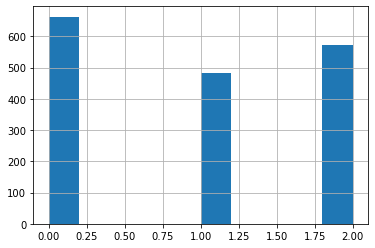

In [257]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(30, df)
df['mytarget'].hist()

<AxesSubplot:xlabel='mytarget', ylabel='Daily_Return'>

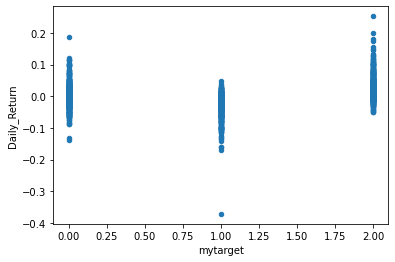

In [258]:
df[["mytarget","Daily_Return"]].plot(kind="scatter", x = "mytarget", y ="Daily_Return")

In [259]:
# from datetime import datetime
# datetime.strptime(df["Date"], '%b %d %Y %I:%M%p')

# df["Date"] = pd.to_datetime((df.Date))
df = df.drop(columns = "Date")

df.head()

KeyError: "['Date'] not found in axis"

In [260]:
df=df.dropna()
X = df.drop(columns=["Daily_Return","mytarget"])

X=X.drop(columns=['Open', 'High', 'Low'])

y=df["mytarget"]
last_train=int(len(X)*.75)
X_train=X.loc[:last_train, :]
X_test=X.loc[last_train:, :]
y_train=y.loc[:last_train]
y_test=y.loc[last_train:]

X_train.head()

,Close,Adj Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
1164,8253.690430,8253.690430,5058610176,442.677361,66.107411,8157.545166,6758.857483,5521.423621,4353.851308,65.611426,45.472807,35.033692,41.737298,-0.551028
1165,8790.919922,8790.919922,4342060032,450.533652,70.985898,8491.034912,6835.490735,5573.846118,4392.867744,64.118529,47.512711,35.681023,57.412130,0.176289
1166,9330.549805,9330.549805,5475579904,465.376938,74.894879,9149.259766,6928.616736,5632.979492,4434.998680,69.296346,50.311008,36.987966,182.252665,1.542398
1167,9818.349609,9818.349609,5653320192,466.498295,77.805763,9585.534668,7034.308228,5702.849487,4479.352177,78.689638,54.845407,38.924571,294.438909,2.478835
1168,10058.799805,10058.799805,6348819968,462.642702,79.092620,9931.000000,7143.065222,5775.758734,4525.412801,90.355843,60.497402,41.467788,395.193352,3.292003


In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#rf=RandomForestClassifier()
rf=GradientBoostingClassifier()
#rf=SVC()

model = rf.fit(X_train_scaled, y_train)

rf_pred_train = model.predict(X_train_scaled)

rf_pred_test = model.predict(X_test_scaled)

In [262]:
display(rf.score(X_train_scaled, y_train))
display(rf.score(X_test_scaled, y_test))

1.0

0.380564263322884

In [263]:
# from sklearn.metrics import classification_report
# print(classification_report(y_train, rf_pred_train))

In [264]:
accuracy_train = accuracy_score(y_train, rf_pred_train)
accuracy_test = accuracy_score(y_test, rf_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df['mytarget'].value_counts()*100/df['mytarget'].count())

Accuracy train: 100.00%
Accuracy test: 38.06%
0.0    38.524114
2.0    33.352702
1.0    28.123184
Name: mytarget, dtype: float64


In [266]:
# Random Model, gambler?
gamble_test = np.random.choice([0, 1, 2], len(rf_pred_test))
accuracy_test = accuracy_score(y_test, gamble_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy Gambler: 33.42%


In [149]:
len(rf_pred)

1603

# Quick analysis example

C:\Users\deerr\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


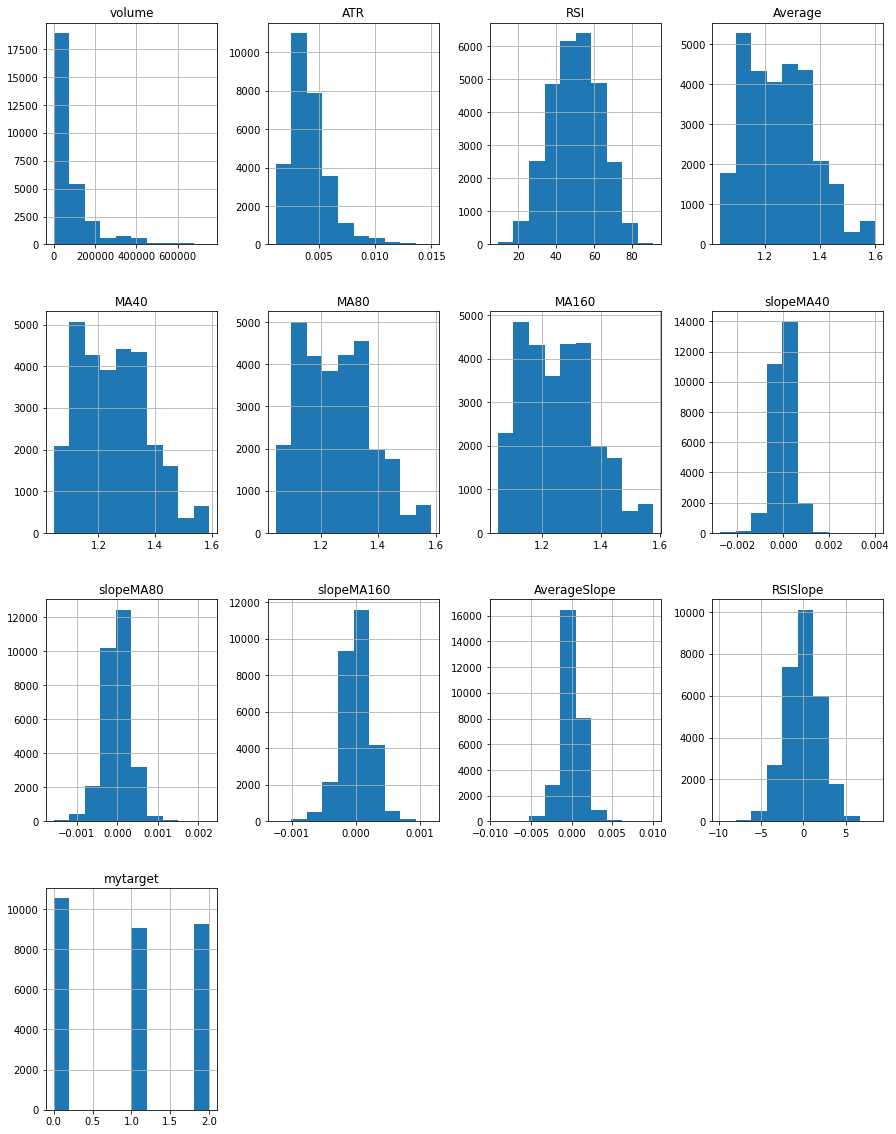

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

## Can we use the RSI alone as a trend indicator?

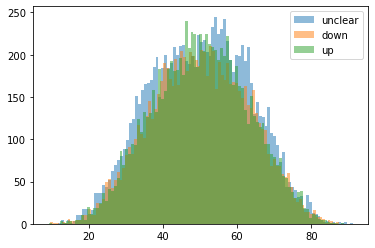

In [8]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

# Machine learning for trend prediction

## 1 - the perfect model with precise prediction

## 2 - less perfect model still with > 40% precision

## 3 - much less perfect model with precision >35% taking into account our strategy, and our TP/SL ratio 

### can't let an automated program run your trades
### it can be your version of a smart indicator (based on machine learning)

## 4 - Our target has categorical values so we need a classificator, KNN?

## Splitting features and target

In [9]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

            ATR        RSI   Average      MA40      MA80     MA160  slopeMA40  \
165    0.004686  47.386257  1.170530  1.172736  1.176061  1.164331  -0.000036   
166    0.004764  55.656867  1.173140  1.172751  1.176156  1.164627  -0.000027   
167    0.004734  57.204154  1.176115  1.172805  1.176219  1.164922  -0.000018   
168    0.004633  53.170749  1.175325  1.172773  1.176158  1.165207  -0.000010   
169    0.004554  55.081423  1.174810  1.172729  1.176124  1.165467  -0.000010   
...         ...        ...       ...       ...       ...       ...        ...   
28837  0.001848  42.935233  1.155445  1.157715  1.162374  1.171109  -0.000059   
28838  0.001830  46.375154  1.156295  1.157628  1.162216  1.170905  -0.000075   
28839  0.001907  37.631843  1.155025  1.157479  1.162006  1.170692  -0.000098   
28840  0.001937  33.174435  1.153790  1.157292  1.161765  1.170473  -0.000121   
28841  0.001894  34.656247  1.152975  1.157129  1.161517  1.170262  -0.000141   

       slopeMA80  slopeMA16

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Fitting the KNN model

In [11]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Quick evaluation of our fitting

In [12]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 38.66%
Accuracy test: 37.46%
0.0    36.545175
2.0    32.034632
1.0    31.420193
Name: mytarget, dtype: float64
Accuracy Gambler: 33.64%


## More powerful model XGBoost

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

ModuleNotFoundError: No module named 'xgboost'

## !!Data sampling shouldn't be random

In [ ]:
#random sampling
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

## Which features are most important for our model?

In [ ]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

# Automated orders using python and Machine Learning
## Previous videos
### 1 - Install Anaconda, Jupyter NB, Pandas_TA (Technical Analysis)
### 2 - Download price data from online resources, and add our technical indicators to our exchange price dataframe
### 3 - Fit a Machine learning model and predict future price trends using KNN and XGBOOST classifiers
### 4 - Save and Load a ML model,
### - according to the model's advice
### - passing orders (sell/buy) automatically
### - send an email notification about newly applied trading operations

## Load Machine Learning Model from Disk and Test it

In [ ]:
import joblib

# save your ML model to disk
filename = 'mymodel1.sav'
joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

## Live Automated Orders with email notification

In [ ]:
from apscheduler.schedulers.blocking import BlockingScheduler
import json
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails


import smtplib
gmail_user = 'email@gmail.com'
gmail_password = 'email password here'
sent_from = gmail_user
to = ['email@gmail.com']
subject = 'info CHF'


In [ ]:
ModelPrediction = 0
def some_job():
    access_token="INSERT TOKEN HERE, YOU GET IT FROM YOUR OANDA ACCOUNT"
    collector = CandleCollector(access_token, Pair.USD_CHF, Gran.H4)
    candles = collector.grab(2*161)

    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    #dfstream['Average'] = (dfstream['High']+dfstream['Low'])/2
    #dfstream['MA40'] = dfstream['Open'].rolling(window=40).mean()
    #dfstream['MA80'] = dfstream['Open'].rolling(window=80).mean()
    #dfstream['MA160'] = dfstream['Open'].rolling(window=160).mean()
    
    import numpy as np
    import pandas_ta as ta
    #attributes=['ATR', 'RSI', 'Average', 
    #'MA40', 'MA80', 'MA160', 'slopeMA40', 
    #'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    dfstream['ATR'] = dfstream.ta.atr(length=20)
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Average'] = dfstream.ta.midprice(length=1) #midprice
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)

#from scipy.stats import linregress
#def get_slope(array):
#    y = np.array(array)
#    x = np.arange(len(y))
#    slope, intercept, r_value, p_value, std_err = linregress(x,y)
#    return slope

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    backrollingN = 6
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    #________________________________________________________________________________________________
    X_stream = dfstream.iloc[[320]]# !!! Index takes last CLOSED candle
    #attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 
    #'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    X_model = X_stream[attributes]
    
    # Apply the model for predictions
    ModelPrediction = loaded_model.predict(X_model)
  
    msg = str(ModelPrediction) # 0 no clear trend, 1 downtrend, 2 uptrend
    #------------------------------------
    # send email with 
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.ehlo()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, msg)
    server.close()
    #________________________________________________________________________________________________
    
    
    # EXECUTING ORDERS
    accountID = "1432-432-0000" #use your account ID
    client = API(access_token)

    candles = collector.grab(1)
#    for candle in candles:
#        print(candle.bid.o)
#        print(candle.bid.c)
    
    pipdiff = 500*1e-5 #for TP
    SLTPRatio = 2 #pipdiff/Ratio gives SL
    
    TPBuy = float(str(candle.bid.o))+pipdiff
    SLBuy = float(str(candle.bid.o))-(pipdiff/SLTPRatio)
    TPSell = float(str(candle.bid.o))-pipdiff
    SLSell = float(str(candle.bid.o))+(pipdiff/SLTPRatio)
    
    #Sell
    if ModelPrediction == 1:
        mo = MarketOrderRequest(instrument="USD_CHF", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif ModelPrediction == 2:
        mo = MarketOrderRequest(instrument="USD_CHF", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

## Executing orders automatically every 4 Hours

In [ ]:
#some_job()

###################################################################
## Interval time job ##############################################
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 15*60})
scheduler.add_job(some_job, 'cron', day_of_week='mon-fri', hour='*/4', minute=5, jitter=120, timezone='America/New_York')
#scheduler.add_job(some_job, 'interval', hours=4)
scheduler.start()